<a href="https://colab.research.google.com/github/suryogumilar/tensorflow_playground/blob/main/C2_W1_Lab_1_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution network classifying cat vs dog

Convolution network based on [Coursera course](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow/)

and [github](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C2/W1/ungraded_lab/C2_W1_Lab_1_cats_vs_dogs.ipynb)

In [17]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files

Download the dataset

In [18]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-12-01 03:24:32--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   238MB/s    in 0.3s    

2022-12-01 03:24:32 (238 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [19]:
# Unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [20]:
base_dir = 'cats_and_dogs_filtered'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['train', 'vectorize.py', 'validation']

Contents of train directory:
['cats', 'dogs']

Contents of validation directory:
['cats', 'dogs']


In [21]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [22]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


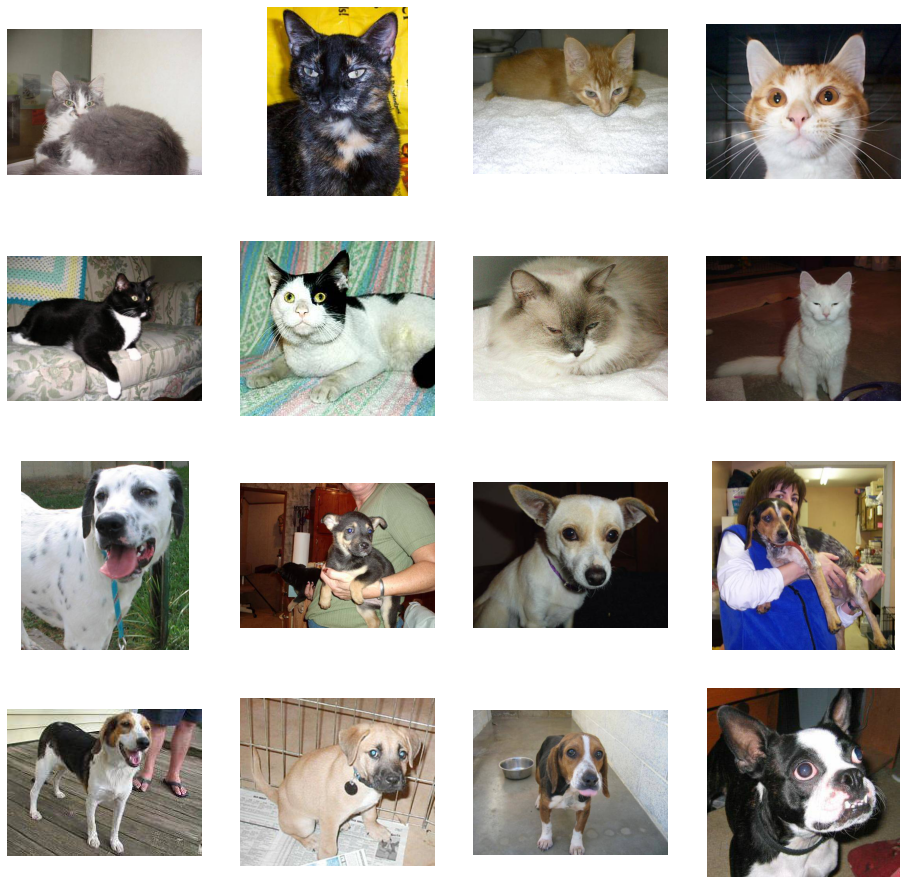

In [23]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to float32 tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras, this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory).

In [24]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### building small model

In [25]:
## set seed so that model has same 'common ground' (it node's weight and bias are the same value on each creation)
tf.random.set_seed(10)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [26]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

### training

In [27]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/15
100/100 - 9s - loss: 0.7692 - accuracy: 0.5560 - val_loss: 0.6463 - val_accuracy: 0.6110 - 9s/epoch - 94ms/step
Epoch 2/15
100/100 - 8s - loss: 0.6454 - accuracy: 0.6695 - val_loss: 0.6253 - val_accuracy: 0.6750 - 8s/epoch - 83ms/step
Epoch 3/15
100/100 - 8s - loss: 0.5442 - accuracy: 0.7420 - val_loss: 0.6107 - val_accuracy: 0.6780 - 8s/epoch - 83ms/step
Epoch 4/15
100/100 - 8s - loss: 0.4527 - accuracy: 0.7875 - val_loss: 0.5823 - val_accuracy: 0.7200 - 8s/epoch - 83ms/step
Epoch 5/15
100/100 - 8s - loss: 0.3579 - accuracy: 0.8455 - val_loss: 0.6852 - val_accuracy: 0.7050 - 8s/epoch - 83ms/step
Epoch 6/15
100/100 - 8s - loss: 0.2594 - accuracy: 0.8870 - val_loss: 0.7156 - val_accuracy: 0.7200 - 8s/epoch - 83ms/step
Epoch 7/15
100/100 - 8s - loss: 0.1781 - accuracy: 0.9265 - val_loss: 0.8005 - val_accuracy: 0.7120 - 8s/epoch - 84ms/step
Epoch 8/15
100/100 - 8s - loss: 0.1130 - accuracy: 0.9580 - val_loss: 1.0361 - val_accuracy: 0.6990 - 8s/epoch - 82ms/step
Epoch 9/15
100/1

### Evaluating Accuracy and Loss for the Model

Text(0.5, 1.0, 'Training and validation loss')

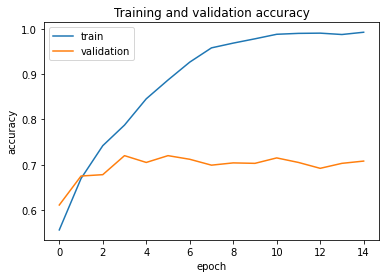

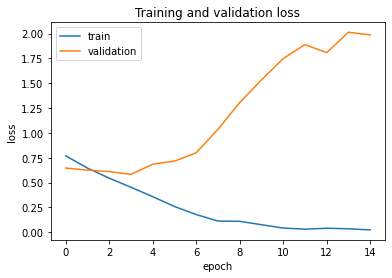

In [28]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.title ('Training and validation loss'   )

**We see problem of overfit!!**

what if we use batch step per epoch?

In [29]:
print('train batch size is:', train_generator.batch_size)
print('train dataset size:', len(train_generator.labels))

print('validation batch size is:', validation_generator.batch_size)
print('validation dataset size:', len(validation_generator.labels))


train batch size is: 20
train dataset size: 2000
validation batch size is: 20
validation dataset size: 1000


In [30]:
train_steps_per_epoch = len(train_generator.labels)/train_generator.batch_size
validation_steps_per_epoch = len(validation_generator.labels)/validation_generator.batch_size

print('train_steps_per_epoch:', train_steps_per_epoch )

print('validation_steps_per_epoch:', validation_steps_per_epoch )

train_steps_per_epoch: 100.0
validation_steps_per_epoch: 50.0


each batch contains 20 image, dataset size for training is 2000 images so in order to train the model using every image in dataset each epoch has to run 100 batch (stepping 100 times) `(2000/20)`

In [31]:
## set seed so that model has same 'common ground' (it node's weight and bias are the same value on each creation)
tf.random.set_seed(10)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 64)      

In [32]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [33]:
history = model.fit(
            train_generator,
            epochs=15, steps_per_epoch=train_steps_per_epoch,
            validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
            verbose=2
            )

Epoch 1/15
100/100 - 9s - loss: 0.9204 - accuracy: 0.5605 - val_loss: 0.6650 - val_accuracy: 0.6600 - 9s/epoch - 92ms/step
Epoch 2/15
100/100 - 8s - loss: 0.6312 - accuracy: 0.6505 - val_loss: 0.8657 - val_accuracy: 0.5480 - 8s/epoch - 83ms/step
Epoch 3/15
100/100 - 8s - loss: 0.5648 - accuracy: 0.7175 - val_loss: 0.5668 - val_accuracy: 0.7140 - 8s/epoch - 82ms/step
Epoch 4/15
100/100 - 8s - loss: 0.4818 - accuracy: 0.7685 - val_loss: 0.6685 - val_accuracy: 0.6910 - 8s/epoch - 83ms/step
Epoch 5/15
100/100 - 8s - loss: 0.3813 - accuracy: 0.8285 - val_loss: 0.6554 - val_accuracy: 0.7000 - 8s/epoch - 82ms/step
Epoch 6/15
100/100 - 11s - loss: 0.3104 - accuracy: 0.8645 - val_loss: 0.7146 - val_accuracy: 0.7010 - 11s/epoch - 106ms/step
Epoch 7/15
100/100 - 8s - loss: 0.2087 - accuracy: 0.9100 - val_loss: 0.7381 - val_accuracy: 0.6810 - 8s/epoch - 80ms/step
Epoch 8/15
100/100 - 8s - loss: 0.1353 - accuracy: 0.9515 - val_loss: 1.0396 - val_accuracy: 0.6930 - 8s/epoch - 81ms/step
Epoch 9/15
10

Text(0.5, 1.0, 'Training and validation loss')

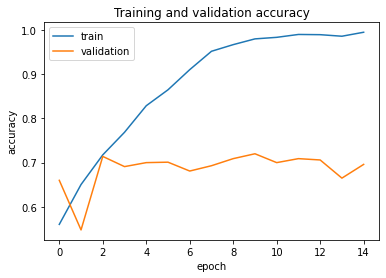

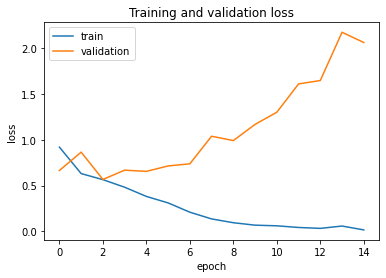

In [34]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.title ('Training and validation loss'   )